# HW2

<img src="https://raw.githubusercontent.com/tensorflow/tpu/master/models/official/efficientnet/g3doc/params.png" width=600 height=300 />

График точности моделей на датасете ImageNet


## Задание 1 (базовое)

Построить аналогичный график accuracy top 5 для различных моделей из Keras (можно на свой выбор) на примере датасета [imagenette](https://github.com/fastai/imagenette). Можете в целом использовать любой из тех, что есть в репозитории, но не забудьте указать какой. Валидация на части `valid` из датасета. 


Более подробные графики с самыми последними результатами можно найти тут: [paperwithcode](https://paperswithcode.com/sota/image-classification-on-imagenet).

В том числе можно попытаться воспользоваться реализацией [FixEfficientNetV2](https://github.com/facebookresearch/FixRes), про которую мы на лекции не говорили, но она есть.

---

Еще ответы на вопросы (которые могут возникнуть):
- Q: Можно я напишу на Tensorflow/PyTorch чистом как моя душа желает?
- A: Да, можно, если я увижу в конце график и подробное описание что на нём.

...

- Q: Обязательно ли делать не базовую часть домашки?
- A: Не обязательно.

...

- Q: У меня проблема с реализацией, что делать?
- A: Пишите в слак в группу.

...


- Q: Можно ли вставлять в домашку смешные картиночки?
- A: Смешные картиночки это очень хорошо.

In [1]:
import numpy as np

from pathlib import Path

In [2]:
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, mobilenet, efficientnet
from tensorflow.keras.applications import imagenet_utils

Если же вам угодно протестировать альтернативные модели, не стесняйтесь

In [3]:
# Набор вспомогательных методов

def get_model(model_name):
    if model_name == 'vgg16':
        model = vgg16.VGG16(weights='imagenet')
    elif model_name == 'inception_v3':
        model = inception_v3.InceptionV3(weights='imagenet')
    elif model_name == 'resnet50':
        model = resnet50.ResNet50(weights='imagenet')
    elif model_name == 'mobilenet':
        model = mobilenet.MobileNet(weights='imagenet')
    elif model_name == 'efficientnet':
        model = efficientnet.EfficientNetB6(weights='imagenet')
    return model

def get_helper_module(model_name):
    if model_name == 'vgg16':
        return vgg16
    elif model_name == 'inception_v3':
        return inception_v3
    elif model_name == 'resnet50':
        return resnet50
    elif model_name == 'mobilenet':
        return mobilenet
    elif model_name == 'efficientnet':
        return efficientnet

In [4]:
MODEL_NAME = 'efficientnet'
dir_path = Path('./imagenette2-160/val/')

model = get_model(MODEL_NAME)
helper_module = get_helper_module(MODEL_NAME)

## Быстрый тест

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

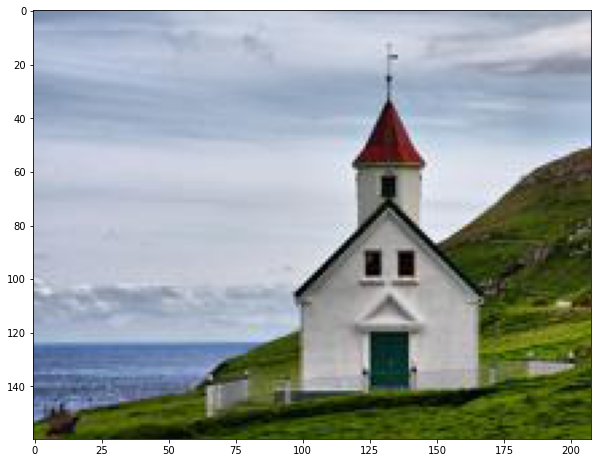

In [6]:
# test image
image = Image.open(dir_path / 'n03028079/ILSVRC2012_val_00004912.JPEG')

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [7]:
# preprocess input
x = image.resize((model.input_shape[1], model.input_shape[1]))
x = helper_module.preprocess_input(x)
x = np.expand_dims(x, 0)

# make prediction and decode
y = model.predict(x)
helper_module.decode_predictions(y)

[[('n03028079', 'church', 0.3857798),
  ('n02814860', 'beacon', 0.085894845),
  ('n02825657', 'bell_cote', 0.06820363),
  ('n03781244', 'monastery', 0.049446754),
  ('n09332890', 'lakeside', 0.021820342)]]

## Подгружаем датасет

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
valid_datagen = ImageDataGenerator(preprocessing_function=helper_module.preprocess_input)

valid_gen = valid_datagen.flow_from_directory(
    dir_path,
    shuffle=False, seed=42, 
    target_size=model.input_shape[1:-1],
    batch_size=32
)

Found 3925 images belonging to 10 classes.


In [10]:
idx_to_label = {v:k for k,v in valid_gen.class_indices.items()}
y_true = [idx_to_label[y] for y in valid_gen.labels]

# надо бы достать правильные значения лейблов из генератора
# удобнее если y_true -- это текстовые метки класса, например: ['n03445777', 'n03942813', 'n04254680', 'n02799071', 'n07760859']

In [11]:
preds = model.predict(valid_gen, steps=1, verbose=1)
preds_decoded = helper_module.decode_predictions(preds, top=5)

1/1 [==============================] - 45s 45s/step


In [12]:
preds_decoded[0]

[('n01440764', 'tench', 0.8066799),
 ('n02514041', 'barracouta', 0.002257538),
 ('n01443537', 'goldfish', 0.0010413971),
 ('n02493793', 'spider_monkey', 0.0008162522),
 ('n04067472', 'reel', 0.0007933472)]

In [13]:
get_codes = lambda item: [i[0] for i in item]
y_pred = [get_codes(item) for item in preds_decoded]
y_pred[0]

['n01440764', 'n02514041', 'n01443537', 'n02493793', 'n04067472']

## Top k accuracy

In [14]:
def top_k_accuracy(y_pred, y_true, k=5):
    # напишите свою реализацию
    right_ans = [y_true_item in y_pred_item[:k]
                 for y_true_item, y_pred_item in zip(y_true, y_pred)]
    return np.mean(right_ans)

In [15]:
top5_accuracy = top_k_accuracy(y_pred, y_true, k=5)
top5_accuracy

1.0

In [16]:
top1_accuracy = top_k_accuracy(y_pred, y_true, k=1)
top1_accuracy

0.90625

## Ваше решение  

Нужно построить график точности моделей от числа ее параметров, подписать где какая модель.

In [17]:
# считаем параметры, делаем предсказания
def pred(model_name, top=5):
    dir_path = Path('./imagenette2-160/val/')

    model = get_model(model_name)
    helper_module = get_helper_module(model_name)
    
    valid_datagen = ImageDataGenerator(preprocessing_function=helper_module.preprocess_input)

    valid_gen = valid_datagen.flow_from_directory(
        dir_path,
        shuffle=False, 
        target_size=model.input_shape[1:-1],
        batch_size=32
    )
    
    idx_to_label = {v:k for k,v in valid_gen.class_indices.items()}
    y_true = [idx_to_label[y] for y in valid_gen.labels]
    
    preds = model.predict(valid_gen, steps=1, verbose=1)
    preds_decoded = helper_module.decode_predictions(preds, top=top)
    get_codes = lambda item: [i[0] for i in item]
    y_pred = [get_codes(item) for item in preds_decoded]
    
    size = sum([w.size for w in  model.get_weights()])

    return size, y_pred, y_true

In [18]:
# сохраняем результаты предсказаний
import pickle

model_results = dict()
for model_name in ['vgg16','inception_v3','resnet50','mobilenet','efficientnet']:
    model_results[model_name] = pred(model_name)

with open('model_results.pkl', 'wb') as f:
    pickle.dump(model_results, f)

Found 3925 images belonging to 10 classes.
1/1 [==============================] - 9s 9s/step
Found 3925 images belonging to 10 classes.
1/1 [==============================] - 5s 5s/step
Found 3925 images belonging to 10 classes.
1/1 [==============================] - 4s 4s/step
Found 3925 images belonging to 10 classes.
1/1 [==============================] - 1s 1s/step
Found 3925 images belonging to 10 classes.
1/1 [==============================] - 46s 46s/step


In [22]:
# строим графики
def plot(model_results, k):
    
    weights, accuracy, annotate = [], [], []
    for model_name, (size, y_pred, y_true) in model_results.items():
        weights.append(size)
        acc = top_k_accuracy(y_pred, y_true, k=k)
        accuracy.append(acc)
        annotate.append([model_name, (size, acc)])

    plt.scatter(weights, accuracy)
    for annot in annotate:
        plt.annotate(*annot)
    plt.xlabel('Number of parameters')
    plt.ylabel(f'Imagenet top-{k} accuracy')
    plt.show()

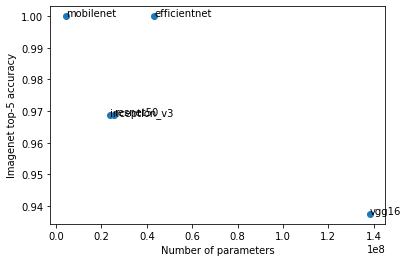

In [23]:
plot(model_results,k=5)

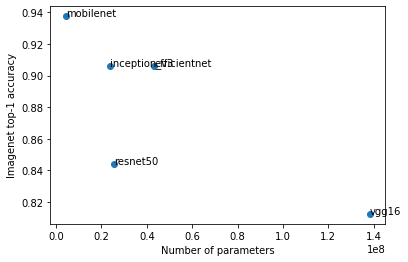

In [24]:
plot(model_results,k=1)

# Bonus part

Бустим креативность

Это может и не поможет вам стать крутым датасайнс-машинлернинг-диплернинг исследователем, но это поможет находить интересное применение простым вещам и возможно делать забавные демки.

## Задание 1

Есть такая штука [ml5.js](https://ml5js.org/), которая позволяет сделать быстро что-то прикольное, не зная особо даже js.

Quick start выглядит так: 

```js
// Step 1: Create an image classifier with MobileNet
const classifier = ml5.imageClassifier("MobileNet", onModelReady);

// Step 2: select an image
const img = document.querySelector("#myImage");

// Step 3: Make a prediction
let prediction = classifier.predict(img, gotResults);

// Step 4: Do something with the results!
function gotResults(err, results) {
  console.log(results);
  // all the amazing things you'll add
}
```

Задача -- сделать интерсное демо использовав эту заготовку (или что-то сложнее по желанию), ссылку на демо вставить в тетрадку с кратким описанием что там происходит.

Для вдохновения: https://andreasref.github.io/sat/

Пример как может выглядеть демка с точки зрения пользователя: https://editor.p5js.org/AndreasRef/sketches/H1L-KrzFQ (работает только если у вас есть камера)

## Задание 2
Если вы чувствуете, что хотите разобраться со свёртками.

Реализовать простенькую forward операцию свёртки, использовав утилиты из файла `im2col.py`

Что надо сделать:

1. Реализовать функцию forward следуя шаблону
2. Задать самостоятельно интересный фильтр, взять картинку любую (лучше из сети) и применить свою `forward` операцию на этой картинке с вашим фильтром (или несколькими, как вам угодно).

In [ ]:
from im2col import im2col_indices

<img src="https://praisethemoon.org/wp-content/uploads/2019/03/giphy-1.gif" width=600 height=500/>

```python
# usage
X_col = im2col_indices(X, h_filter, w_filter, padding=padding, stride=stride)

```

Функция `im2col_indices` вытягивает все те места, которые мы должны умножать на фильтры, в одну матрицу как на гифке.

Еще пример -- если мы делаем свертку 3х3 со страйдом 1 и паддингом 1, то

* Если `X` размера [1x1x10x10], (1 одноканальная картинка размера 10*10) то `X_col` будет матрицей [9x100].
* Если `X` размера [5x1x10x10], (5 одноканальных картинок размера 10*10) то `X_col` будет матрицей [9x500].

In [ ]:
def forward(X, W, b, stride=1, padding=1):
    """
    X: DxCxHxW, где D - количество картинок на входе, C - каналы
    W: NFxCxHFxHW - фильтры, свернутые в одну матрицу,
        * NF - количество фильтров
        * C - то же C - количество каналов в картинке
        * HF, HW - высота и ширина фильтра
    b: Fx1 - параметр байеса
    
    """
    
    X_col = im2col_indices(X, h_filter, w_filter, padding=padding, stride=stride)
    # 1. преобразуйте матрицу W в подходящую размерность;
    # 2. посчитайте дот продукт (в numpy эта операция @) между X_col и матрицей фильтров нужной размерности;
    # 3. прибавьте байес
    # 4. преобразуйте полученное нечто в правильную размерность и верните результат

In [ ]:
# Здесь визуализация с вашим фильтром (заданным руками, можете сделать его даже из 0 и 1 чтобы было нагляднее)